## User and environment definitions

In [1]:
input_file='../../ftransfer_ztf_2024-02-01_689626'

In [2]:
%ls -d $input_file

../../ftransfer_ztf_2024-02-01_689626/


## Python imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#

# 1) Upload data

Initially, we acquired the data from FINK using the link provided: https://fink-portal.org/download.

#### Now, let's import the data into Pandas.

In [4]:
pdf = pd.read_parquet(input_file)

In [5]:
pdf.head(2)

,candid,schemavsn,publisher,objectId,candidate,prv_candidates,cutoutScience,cutoutTemplate,cutoutDifference,cdsxmatch,...,fink_broker_version,fink_science_version,timestamp,year,month,day,tnsclass,lc_features_g,lc_features_r,finkclass
0,1356264842615015004,3.3,Fink,ZTF17aaaeclk,"{'aimage': 0.7979999780654907, 'aimagerat': 0....","[{'aimage': 0.75, 'aimagerat': 0.3048779964447...",{'fileName': 'candid1356264842615015004_pid135...,{'fileName': 'candid1356264842615015004_ref.fi...,{'fileName': 'candid1356264842615015004_pid135...,**,...,1.4,0.5.1,2020-09-18 06:21:22.996783,2020,9,18,Unknown,"{'amplitude': 0.8889999389648438, 'anderson_da...","{'amplitude': None, 'anderson_darling_normal':...",**
1,1356465031915010013,3.3,Fink,ZTF17aaarimh,"{'aimage': 0.5720000267028809, 'aimagerat': 0....","[{'aimage': None, 'aimagerat': None, 'bimage':...",{'fileName': 'candid1356465031915010013_pid135...,{'fileName': 'candid1356465031915010013_ref.fi...,{'fileName': 'candid1356465031915010013_pid135...,**,...,1.4,0.5.1,2020-09-18 11:09:38.99808,2020,9,18,Unknown,"{'amplitude': 0.8722000122070312, 'anderson_da...","{'amplitude': 1.0413002967834473, 'anderson_da...",**


#### Here we calculate the first and last days on which an alert was recorded across all the data. 
we're identifying the earliest and latest dates observed across all the alerts in the entire dataset.

In [6]:
jd_series = pdf.candidate.apply(lambda a:a['jd'])
last_day = jd_series.max()

first_day = np.min(pdf.prv_candidates.apply(lambda a: a[0]['jd']))

In [7]:
last_day, first_day

(2459111.0274074, 2459080.6432407)

#

# 2) Select alert and build the data Frame

### We select alerts (data) based on their shared ID 

In [9]:
Id = pdf['objectId'][4771]

id_most_repeated = pdf['objectId'].value_counts().idxmax()

Id = "ZTF18acoyqvk" # max by j (for all Q) here we got = 119 on idx = 13 (all Q matched)
# Id = "ZTF18abosdhe" #min by j ,  ( idx = 5 , with one Q )

#Id = "ZTF18adarfuu" # max by Q idx = 6
Id = "ZTF18aaxyrcb" # min by Q idx = 7
Id = "ZTF19abizgyw" # <10 data 

Id = "ZTF18acckcza" # Anomaly data analysis 
Id = "ZTF18acevrat" # probUpperlim
Id = "ZTF17aaafgst" # prob stop
Id = "ZTF17aacezky"
Id = "ZTF18abhqeds" # no dc_mag ! 
Id = "ZTF17aaaenex" # ratio 35 we still have upp prob
Id = "ZTF17aabunxe"
Id = "ZTF18aawawpd" #prob only 1 red 
Id = "ZTF18abcpbbw" # strange warrnning /
Id = "ZTF18acgzsug"
Id = "ZTF18aabeypj" # middele 
Id =  "ZTF18abwpcbt" #problem in GP ! wrong values 
Id = "ZTF20abvtozi" #Sn
# Id = "ZTF20abvrxkz" #SN problem in GP ! wrong values 
pdf_filter_by_shared_Id = pdf.loc[pdf['objectId'] == Id]

### Choose the last alert 

In [10]:
candidate_df = pdf_filter_by_shared_Id['candidate'].apply(pd.Series)

candidate_df = candidate_df.sort_values(by= 'jd')
index_max_jd = candidate_df.index[-1]

# select this candidate
pdf_last_alert = pdf_filter_by_shared_Id.loc[index_max_jd]

### Transform the data of all candidates (including `prv_candidates` and the last one) into a DataFrame.

In [11]:
pdf_selec_cands = pdf_last_alert['prv_candidates'] 

In [12]:
#  add 'candidate' the actual value 
keys = pdf_selec_cands[0].keys()
latest_cand = {key: pdf_last_alert['candidate'][key] for key in keys if key in pdf_last_alert['candidate']}

In [13]:
liste_dicts = list(pdf_selec_cands)
liste_dicts.append(latest_cand)
df = pd.DataFrame(liste_dicts)

#

# 3) plot Difference Magnitude in Modified Julian Date [UTC]


_Circles (●) with error bars show valid alerts that pass the Fink quality cuts.
In addition, the Difference magnitude view shows:

_upper triangles with errors (▲), representing alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.

_lower triangles (▽), representing 5-sigma magnitude limit in difference image based on PSF-fit photometry contained in the history of valid alerts.

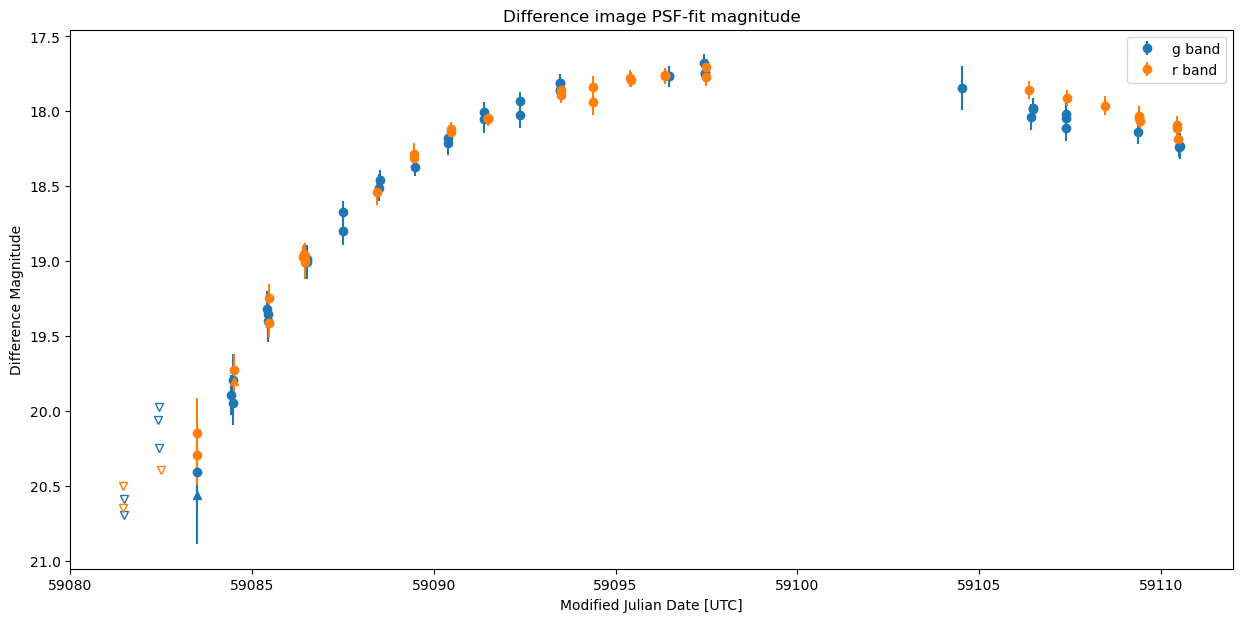

In [14]:
fig = plt.figure(figsize=(15, 7))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

# valid values 
maskValid = (df['rb'] >= 0.55) & (df['nbad'] == 0) #& (abs(df['magdiff']) <= 0.1)# magdiff = magap - magpsf
# Upper limit values
maskUpper = pd.isna(df['magpsf'])
#bad quality values 
maskBadquality = ~maskValid & ~maskUpper

for filt in np.unique(df['fid']):
    maskFilt = df['fid'] == filt

    plt.errorbar(
        df[maskValid & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt]['magpsf'],
        df[maskValid & maskFilt]['sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    plt.plot(
        df[maskUpper & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskUpper & maskFilt]['diffmaglim'],
        ls='', marker='v', color=colordic[filt], markerfacecolor='none'
    )
    

    plt.errorbar(
        df[maskBadquality & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskBadquality & maskFilt]['magpsf'],
        df[maskBadquality & maskFilt]['sigmapsf'],
        ls='', marker='^', color=colordic[filt]
    )

#plt.ylim(14, 18)
#plt.xlim(59084, 59086)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');


# Plot the magnitude difference for valid data.

Distinguishing between positive differences represented by circles and negative differences represented by triangles.

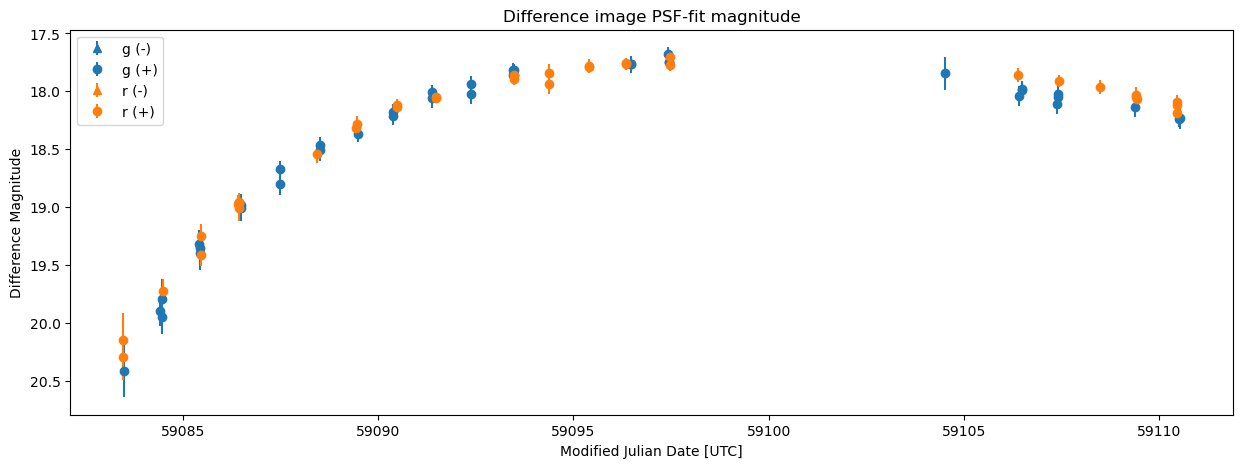

In [15]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}
    
maskValid = (df['rb'] >= 0.55) & (df['nbad'] == 0)

    
#t or 1 => candidate is from positive (sci minus ref) subtraction;
#f or 0 => candidate is from negative (ref minus sci) subtraction"
maskpos = (df['isdiffpos'] == 't') | (df['isdiffpos'] == '1')
maskneg = (df['isdiffpos'] == 'f') | (df['isdiffpos'] == '0')

for filt in np.unique(df['fid']):
    maskFilt = df['fid'] == filt

    # candidates from negative 

    plt.errorbar(
        df[maskValid & maskFilt & maskneg ]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt & maskneg ]['magpsf'],
        df[maskValid & maskFilt & maskneg ]['sigmapsf'],
        ls = '', marker='^', color=colordic[filt], label='{} (-)'.format(filtdic[filt])
    )
    
    # candidates from positive 
    plt.errorbar(
        df[maskValid & maskFilt &  maskpos ]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt &  maskpos ]['magpsf'],
        df[maskValid & maskFilt &  maskpos ]['sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} (+)'.format(filtdic[filt])
    )
    

#plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



# 

# 4) Calculate and plot Apparent DC flux for the valid data

We utilize a function(`apparent_flux_New`) located within our `FAnomAly` package to compute the apparent flux for the valid data.

In [16]:
from fink_utils.photometry.utils import is_source_behind
from FAnomAly.flux import apparent_flux_New

# Take only valid measurements
maskValid = (df['rb'] >= 0.55) & (df['nbad'] == 0)
df_valid = df[maskValid].sort_values('jd')
df_valid['is_Source'] = is_source_behind(df_valid['distnr'])


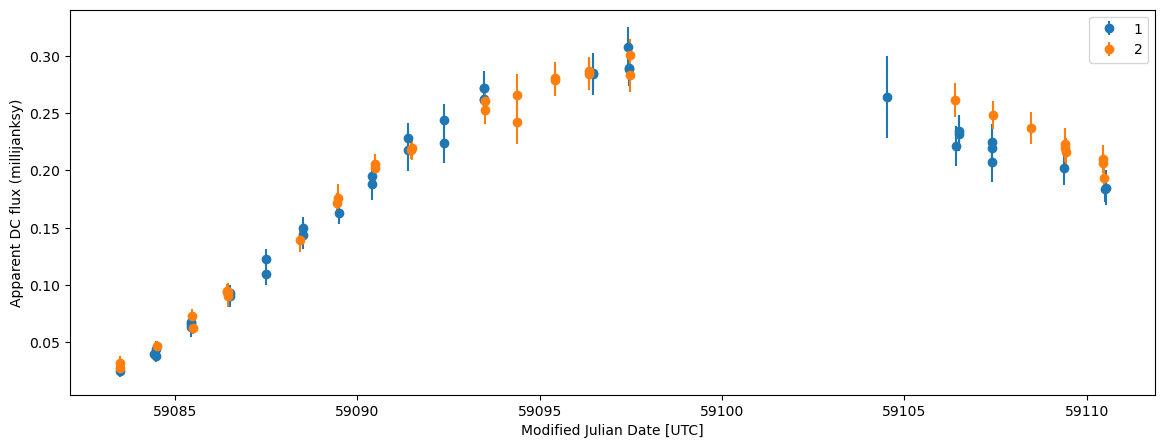

In [17]:
fig = plt.figure(figsize=(14, 5))

dc_flux, dc_sigflux = np.transpose(
        [
            apparent_flux_New(*args, jansky=True) for args in zip(
                df_valid['magpsf'].astype(float).values,
                df_valid['sigmapsf'].astype(float).values,
                df_valid['magnr'].astype(float).values,
                df_valid['sigmagnr'].astype(float).values,
                df_valid['isdiffpos'].values,
                df_valid['is_Source'].astype(bool).values

            )
        ]
)

df_valid['dc_flux'] = dc_flux
df_valid['dc_sigflux'] = dc_sigflux



for filt in np.unique(df['fid']):
    mask = df_valid['fid'] == filt
    sub = df_valid[mask]
    plt.errorbar(
        sub['jd'].apply(lambda x: x - 2400000.5),
        sub['dc_flux']*1e3,
        sub['dc_sigflux']*1e3,
        ls='', 
        marker='o',
        label=str(filt)
    )
plt.legend()

plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Apparent DC flux (millijanksy)');


## Apparent flux for the nearest source

We create a function `flux_nr` to determine the apparent flux for the nearest source in the reference image.

Please don't overlook downloading the FAnomAly package.

In [18]:
from FAnomAly.flux import flux_nr

nr_flux, nr_sigflux = np.transpose(
        [
            flux_nr(*args, jansky=True) for args in zip(
                df_valid['magnr'].astype(float).values,
                df_valid['sigmagnr'].astype(float).values
            )
        ]
)

df_valid['nr_flux'] = nr_flux
df_valid['nr_sigflux'] = nr_sigflux


# 

# 5) Important steps 


#### Convert 'mjd' to integer to remove fractional part


In [19]:
df_valid['mjd'] = (df_valid['jd'] - 2400000.5).astype(int)

In [20]:
min_mjd = int(first_day - 2400000.5) #df_by_days['mjd'].min()
max_mjd = int(last_day  - 2400000.5)

# 

Here we check if we are on the case of only one pass band (there are valid data only for red filter or only for green)

In [21]:
df_valid['source'] = 1

In [22]:
if len(df_valid[df_valid['fid'] == 1]) ==0 : 
    
    # We append two data points with zero values. This aids our algorithm without introducing any risk.
    new_rows = pd.DataFrame({'fid': [1, 1],
                             'mjd': [first_day - 2400000.5, last_day - 2400000.5],#[df_valid['jd'].min(), df_valid['jd'].max()],
                             'dc_flux': [0, 0],
                             'dc_sigflux': [0, 0],
                             'nr_flux' : [0,0],
                             'nr_sigflux':[0,0], 
                             'source': [0,0],
                            })

    df_valid = pd.concat([df_valid, new_rows], ignore_index=True)

elif len(df_valid[df_valid['fid'] == 2]) ==0 :     
        
    new_rows = pd.DataFrame({'fid': [2, 2],
                             'mjd': [first_day - 2400000.5, last_day - 2400000.5],
                             'dc_flux': [0, 0],
                             'dc_sigflux': [0, 0],
                             'nr_flux' : [0,0],
                             'nr_sigflux':[0,0],
                             'source': [0,0],

                           })

    df_valid = pd.concat([df_valid, new_rows], ignore_index=True)

# 

# 6) Features extraction

We extract the specific columns from the valid data as needed.

In [23]:
columns_to_keep = ['mjd', 'fid','dc_flux', 'dc_sigflux','nr_flux', 'nr_sigflux','source']

combined_df = df_valid[columns_to_keep].copy()

In [24]:
combined_df.sort_index(inplace=True)

In [25]:
combined_df.head(2)

,mjd,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux,source
8,59083,2,0.000028,0.000005,0.000004,6.939978e-07,1
9,59083,2,0.000032,0.000007,0.000005,1.092741e-06,1


# 

# 7) Data by days 

Here, we group the data by modified Julian date on a daily basis and by filter ID (1 for g, 2 for R), computing the average values of flux and sigma flux(for both DC and NR) using the `Weighted_Mean` functions.

#### group the data by mjd and by filter

#### calculate the average values

We extract the initial value from the 'source' column within each group. It's noteworthy that on any given day (represented by 'r/g'), there might be either missing data or available data.

In [26]:
from FAnomAly.Weighted_Mean import Weighted_Mean_general

combined_df = df_valid[columns_to_keep].copy()
df_group = combined_df.groupby(['mjd','fid'])

# df_by_days = pd.DataFrame()
df_by_days_dc = df_group.apply(Weighted_Mean_general, flux_col='dc_flux', sigflux_col='dc_sigflux')


# Apply Weighted_Mean_general on 'nr_flux' and 'nr_sigflux'
df_by_days_nr = df_group.apply(Weighted_Mean_general, flux_col='nr_flux', sigflux_col='nr_sigflux')

df_by_days_source = df_group['source'].apply(lambda x: x.value_counts().idxmax())

# Merge the results based on 'mjd' and 'fid'
df_by_days = pd.merge(df_by_days_dc, df_by_days_nr, on=['mjd', 'fid'], suffixes=('_dc', '_nr'))
df_by_days = pd.merge(df_by_days, df_by_days_source, on=['mjd', 'fid'])
df_by_days.reset_index(inplace=True)

In [27]:
df_by_days.head(4)

,mjd,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux,source
0,59083,1,0.000025,0.000005,0.000003,5.414409e-07,1
1,59083,2,0.000029,0.000004,0.000004,5.858348e-07,1
2,59084,1,0.000040,0.000003,0.000003,3.591450e-07,1
3,59084,2,0.000047,0.000004,0.000004,6.939978e-07,1


# 

# 8) Compute the regression of missing days with Gaussian Process ! 

In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

kernel =  ConstantKernel(constant_value=1.e-6, constant_value_bounds=(1e-12, 1)) * RBF(length_scale=5.0, length_scale_bounds=(5e-1, 5e2))

def Gaussian_Process(df,flux= 'dc_flux',sigflux= 'dc_sigflux'):
    mean_prediction = {}
    std_prediction = {}
    for filt in np.unique(df.fid):
        X_train=df[df.fid==filt].mjd.values.reshape(-1, 1)
        Y_train=np.squeeze(df[df.fid==filt][f'{flux}'].values)
        Sig_train = np.squeeze(df[df.fid==filt][f'{sigflux}'].values)
        X=np.arange(min_mjd,max_mjd+1,1).reshape(-1, 1)
        # print(X)


        if len(X_train) == 1 : 
            # If there's only one training point, create a series of mean predictions and high error bars
            print(Y_train)
            mean_prediction[filt] = np.full((max_mjd - min_mjd + 1,), float(Y_train))
            std_prediction[filt] = np.full((max_mjd - min_mjd + 1,), 1 * float(Sig_train))
            
        else :
            
        
            gaussian_process = GaussianProcessRegressor( kernel=kernel, alpha=Sig_train**2, n_restarts_optimizer=9 )
            gaussian_process.fit(X_train, Y_train)
            mean_prediction[filt], std_prediction[filt] = gaussian_process.predict(X, return_std=True)
        
        plt.errorbar(
            X_train, Y_train, Sig_train,
            ls='', 
            marker='o',
            color=colordic[filt], 
            label=f"{filt} valid difference flux"
        )
    
        plt.plot(
            X,mean_prediction[filt], c=colordic[filt], 
            label=f"{filt} GP prediction"
        )
    
        plt.fill_between(
            X[:,0],mean_prediction[filt]+std_prediction[filt], mean_prediction[filt]-std_prediction[filt],color=colordic[filt], alpha=0.3
        )
        plt.show
    return mean_prediction, std_prediction


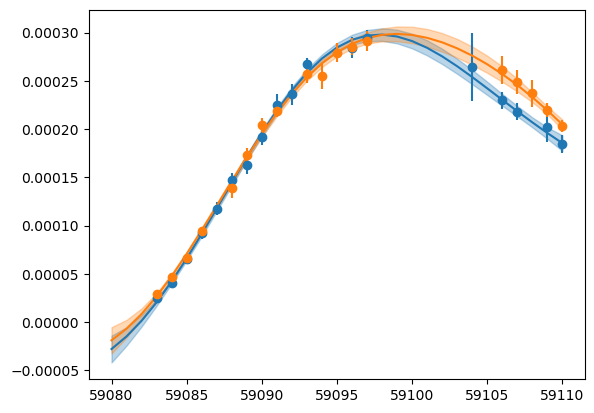

In [29]:
dc_flux = {}
dc_sigflux_pred = {}

nr_flux_pred = {}
nr_sigflux_pred = {}

plt.figure()

dc_flux_pred,dc_sigflux_pred = Gaussian_Process(df_by_days, "dc_flux","dc_sigflux")


# 

# 

# 

# 9) Fill the missing days ! 

If there are missing days (without alerts in the data), we can fill these gaps with predictions from GP regression values.

In [30]:
from FAnomAly.Weighted_Mean import Weighted_Mean_all

# # Create a DataFrame all_days containing a range of MJD values from the minimum to the maximum MJD found in df_by_days.
all_days = pd.DataFrame({'mjd': range(min_mjd, max_mjd + 1)}) # + 1 i need to check this one ! 

df_extended = df_by_days.copy()

# Inside your loop for handling missing days
for filt in np.unique(df_extended['fid']):
    mask = df_extended['fid'] == filt
    data_days = df_extended[mask]['mjd']
    sub = df_extended[mask]
    
    missing_days = ~all_days['mjd'].isin(data_days)
    df_missing_days = all_days[missing_days].copy()  # Ensure a copy to avoid chain indexing issues
    
    true_indices = missing_days[missing_days].index.tolist()


    df_missing_days['dc_flux'] = dc_flux_pred[filt][true_indices]
    df_missing_days['dc_sigflux'] = dc_sigflux_pred[filt][true_indices]
    
    df_missing_days['fid'] = filt
    df_missing_days['source'] = 0

    # Append the missing data to df_extended
    columns_to_keep = ['mjd', 'fid','dc_flux', 'dc_sigflux','source']
    df_extended = pd.concat([df_extended, df_missing_days], ignore_index=True, sort=False)

df_extended = df_extended[columns_to_keep].sort_values(by=['mjd', 'fid'])

df_extended.reset_index(drop=True, inplace=True)


In [31]:
df_extended.head(10)

,mjd,fid,dc_flux,dc_sigflux,source
0,59080,1,-0.000028,0.000014,0
1,59080,2,-0.000019,0.000014,0
2,59081,1,-0.000015,0.000009,0
3,59081,2,-0.000007,0.000009,0
4,59082,1,0.000001,0.000006,0
5,59082,2,0.000008,0.000006,0
6,59083,1,0.000025,0.000005,1
7,59083,2,0.000029,0.000004,1
8,59084,1,0.000040,0.000003,1
9,59084,2,0.000047,0.000004,1


In [32]:
df_extended.shape

(62, 5)

### plot apparent  DC and nr flux in millijanksy 

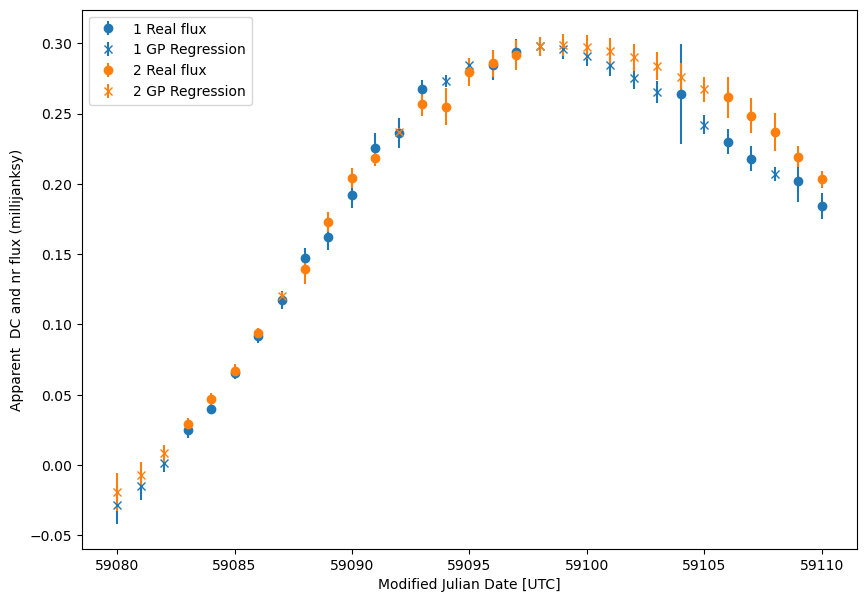

In [33]:
fig = plt.figure(figsize=(10, 7))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}


for filt in np.unique(df_extended['fid']):
    mask = df_extended['fid'] == filt
    mask_missing =  df_extended['source'] == 0
    mask_original = df_extended['source'] == 1
    sub2 = df_extended[mask & mask_missing]
    sub = df_extended[mask & mask_original]
    
    plt.errorbar(
        sub['mjd'],
        sub['dc_flux']*1e3, 
        sub['dc_sigflux']*1e3,
        ls='', 
        marker='o',
        color=colordic[filt], 

        label=f"{filt} Real flux"
    )
    plt.errorbar(
        sub2['mjd'],
        sub2['dc_flux']*1e3 ,#+ sub2['nr_flux']*1e3, 
        sub2['dc_sigflux']*1e3,# + sub2['nr_sigflux']*1e3,
        ls='', 
        marker='x',
        color=colordic[filt], 

        label=f"{filt} GP Regression"
    )
    
    
    
    
plt.legend()

plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Apparent  DC and nr flux (millijanksy)');

# 

# 10) Create a final dataframe to consolidate the values of this alert into a single row.

In this dataframe, include another dataframe as a dictionary containing the values of mjd,flux, sigma, and so on.

In [34]:
df_anomaly = pd.DataFrame()
df_anomaly['objectId'] = [pdf_last_alert.objectId]
df_anomaly['candid'] = [pdf_last_alert.candid]
df_anomaly['jd'] = [pdf_last_alert.candidate['jd']]
df_anomaly['df'] = [df_extended.to_dict()]

In [35]:
df_anomaly

,objectId,candid,jd,df
0,ZTF20abvtozi,1356526944615015011,2.459111e+06,"{'mjd': {0: 59080, 1: 59080, 2: 59081, 3: 5908..."


In [36]:
#Here's an example of how we can utilize the dataframe of the first row:
df_test = pd.DataFrame.from_dict(df_anomaly['df'].iloc[0])

In [37]:
df_test.head(5)

,mjd,fid,dc_flux,dc_sigflux,source
0,59080,1,-0.000028,0.000014,0
1,59080,2,-0.000019,0.000014,0
2,59081,1,-0.000015,0.000009,0
3,59081,2,-0.000007,0.000009,0
4,59082,1,0.000001,0.000006,0
